In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [2]:
df = pd.read_json('transactions.txt', lines=True)

df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


## Data Cleaning

In [3]:
# Replacing white space with nan

df = df.replace('', np.nan)

C:\Users\brian\AppData\Local\Temp\ipykernel_34736\2814523631.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('', np.nan)


In [4]:
# Checking which columns are empty and removing

nan_col = df.columns[df.isna().all()].tolist()
df.drop(columns=nan_col, inplace=True)

print("Empty columns that were removed:")
print(nan_col)

Empty columns that were removed:
['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']


In [5]:
# Account Number and Customer Id columns appear to be equal

df['accountNumber'].equals(df['customerId'])

True

In [6]:
# Removing customerId as it is a duplicate of accountNumber

df.drop(columns=['customerId'], inplace=True)

In [7]:
# Dropping merchantName as merchantCategory will be used
df.drop(columns=['merchantName'], inplace=True)

In [8]:
# Need to remove remaining unneeded columns
#df.drop(columns=['cardCVV'], inplace=True)
#df.drop(columns=['enteredCVV'], inplace=True)
df.drop(columns=['cardLast4Digits'], inplace=True)

In [9]:
# Filling NaN with purchase to keep data

df['transactionType'] = df['transactionType'].fillna('PURCHASE')

In [10]:
# Total amount of rows with NaN values
df.isnull().any(axis=1).sum()

9003

In [11]:
# Dropping all rows with NaN value
df = df.dropna()

In [12]:
pd.pandas.set_option('display.max_columns', None)

In [13]:
# Changing transactionDatetime. All transactions occurred in 2016, year is unneeded.

df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])
df['Month'] = df['transactionDateTime'].dt.month
df['day'] = df['transactionDateTime'].dt.day
df['hour'] = df['transactionDateTime'].dt.hour
df['minute'] = df['transactionDateTime'].dt.minute

# Cyclic encoding for hour and minute
df['hourSin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hourCos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['minuteSin'] = np.sin(2 * np.pi * df['minute'] / 24)
df['minuteCos'] = np.cos(2 * np.pi * df['minute'] / 24)

# Do not need columns
df.drop(columns=['transactionDateTime'], inplace=True)
df.drop(columns=['hour'], inplace=True)
df.drop(columns=['minute'], inplace=True)

In [14]:
# Reformatting other date columns

df['expYear'] = pd.to_datetime(df['currentExpDate']).dt.year
df['expMonth'] = pd.to_datetime(df['currentExpDate']).dt.month

df['accountOpenYear'] = pd.to_datetime(df['accountOpenDate']).dt.year
df['accountOpenMonth'] = pd.to_datetime(df['accountOpenDate']).dt.month
df['accountOpenDay'] = pd.to_datetime(df['accountOpenDate']).dt.day

df['lastAddressChangeYear'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.year
df['lastAddressChangeMonth'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.month
df['lastAddressChangeDay'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.day

# removing unneeded columns
df.drop(columns=['currentExpDate'], inplace=True)
df.drop(columns=['accountOpenDate'], inplace=True)
df.drop(columns=['dateOfLastAddressChange'], inplace=True)

C:\Users\brian\AppData\Local\Temp\ipykernel_34736\3371426977.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expYear'] = pd.to_datetime(df['currentExpDate']).dt.year
C:\Users\brian\AppData\Local\Temp\ipykernel_34736\3371426977.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expMonth'] = pd.to_datetime(df['currentExpDate']).dt.month


## Encoding

In [15]:
# Categorical columns that need to be endocded

columns_to_encode = ['acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'transactionType', 'merchantCategoryCode']
df = pd.get_dummies(df, columns=columns_to_encode, prefix=columns_to_encode)

# Convert boolean columns to integers
df['cardPresent'] = df['cardPresent'].astype(int)
df['expirationDateKeyInMatch'] = df['expirationDateKeyInMatch'].astype(int)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 777360 entries, 0 to 786362
Data columns (total 62 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   accountNumber                              777360 non-null  int64  
 1   creditLimit                                777360 non-null  int64  
 2   availableMoney                             777360 non-null  float64
 3   transactionAmount                          777360 non-null  float64
 4   cardCVV                                    777360 non-null  int64  
 5   enteredCVV                                 777360 non-null  int64  
 6   currentBalance                             777360 non-null  float64
 7   cardPresent                                777360 non-null  int32  
 8   expirationDateKeyInMatch                   777360 non-null  int32  
 9   isFraud                                    777360 non-null  bool   
 10  Month        

In [17]:
# Breaking apart features and labels

features = df.iloc[:, :-1]
labels = df['isFraud']

## Splitting dataset into train, test and val

In [18]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

np.random.seed(33)
tf.random.set_seed(33)

X = df.drop('isFraud', axis = 1)
Y = df['isFraud']

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=33, stratify=Y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=33, stratify=y_temp)


In [19]:
np.random.seed(33)
tf.random.set_seed(33)

#standardize/normalize numerical features
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numerical_features = features.select_dtypes(include=['float64', 'int64'])
numerical_columns = numerical_features.columns
ct = ColumnTransformer([("only numeric", StandardScaler(), numerical_columns)], remainder='passthrough')

x_train_scaled = ct.fit_transform(x_train)
x_train_scaled = x_train_scaled.astype('float32')
x_test_scaled = ct.transform(x_test)
x_test_scaled = x_test_scaled.astype('float32')
x_val_scaled = ct.transform(x_val)
x_val_scaled = x_val_scaled.astype('float32')

## Testing Function

In [20]:
# Function to test the model threshold to procude the best f1 score and produce results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def test_metrics(model, x_test, y_test):
    y_pred = model.predict(x_test)

    # Find the best threshold for F1 score
    thresholds = np.linspace(0, 1, 1001)
    f1_scores = []
    for thresh in thresholds:
        y_pred_binary = (y_pred >= thresh).astype(int)
        f1 = f1_score(y_test, y_pred_binary)
        f1_scores.append(f1)
    
    # Get the best threshold
    max_f1_index = np.argmax(f1_scores) 
    best_threshold = thresholds[max_f1_index]
    best_f1 = f1_scores[max_f1_index]

    # Use the best threshold to get final predictions
    y_pred_binary = (y_pred >= best_threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    auc = roc_auc_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred_binary)

    # Print metrics
    print(f"Best Threshold: {best_threshold}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {best_f1}")
    print(f"AUC: {auc}")
    print("Confusion Matrix:")
    print(cm)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary)

    metrics = {
        'Best Threshold': best_threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': best_f1,
        'AUC': auc,
        'Confusion Matrix': cm
    }
    return metrics
    

## Model Creation  
## Neural Network

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


model_1 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [22]:
model_1.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()]
)

In [23]:

history = model_1.fit(x_train_scaled, y_train, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10

17005/17005 [==============================] - 19s 1ms/step - loss: 0.3465 - binary_accuracy: 0.9814 - recall: 0.0051 - val_loss: 0.0878 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 2/10
17005/17005 [==============================] - 18s 1ms/step - loss: 0.0788 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0748 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 3/10
17005/17005 [==============================] - 20s 1ms/step - loss: 0.0769 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0749 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 4/10
17005/17005 [==============================] - 18s 1ms/step - loss: 0.0761 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0748 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 5/10
17005/17005 [==============================] - 18s 1ms/step - loss: 0.0759 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0758 - val_binary_accuracy: 

3644/3644 [==============================] - 2s 594us/step
Best Threshold: 0.054
Accuracy: 0.9514253370381806
Precision: 0.07157101706182141
Recall: 0.17974401780745689
F1-Score: 0.10237717908082408
AUC: 0.7450086140307604
Confusion Matrix:
[[110617   4190]
 [  1474    323]]


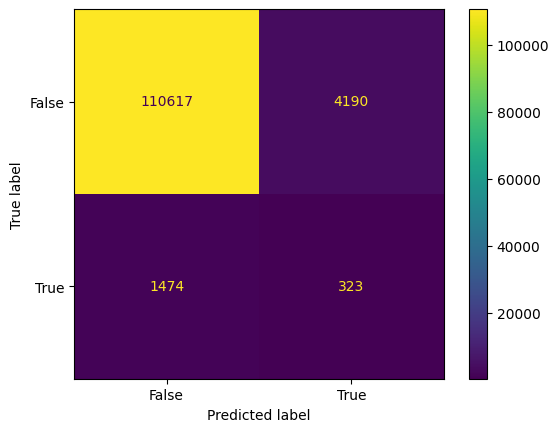

In [24]:
m1_test_results = test_metrics(model_1, x_test_scaled, y_test)

## Model Creation with SMOTE

In [25]:
np.random.seed(33)
tf.random.set_seed(33)
# Applying SMOTE to address the class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=33)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [26]:
np.random.seed(33)
tf.random.set_seed(33)

#standardize/normalize numerical features

numerical_features = features.select_dtypes(include=['float64', 'int64'])
numerical_columns = numerical_features.columns 
ct = ColumnTransformer([("only numeric", StandardScaler(), numerical_columns)], remainder='passthrough')

x_train_scaled = ct.fit_transform(x_train_resampled)
x_train_scaled = x_train_scaled.astype('float32')
x_test_scaled = ct.transform(x_test)
x_test_scaled = x_test_scaled.astype('float32')
x_val_scaled = ct.transform(x_val)
x_val_scaled = x_val_scaled.astype('float32')

In [27]:
np.random.seed(33)
tf.random.set_seed(33)

model_2 = Sequential([
    Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [28]:
model_2.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()]
)

In [29]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_2.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 36s 1ms/step - loss: 0.4562 - binary_accuracy: 0.8247 - recall_1: 0.8077 - val_loss: 0.5115 - val_binary_accuracy: 0.7371 - val_recall_1: 0.5899
Epoch 2/10
33486/33486 [==============================] - 31s 933us/step - loss: 0.2613 - binary_accuracy: 0.8927 - recall_1: 0.8408 - val_loss: 0.2156 - val_binary_accuracy: 0.9521 - val_recall_1: 0.1697
Epoch 3/10
33486/33486 [==============================] - 31s 931us/step - loss: 0.2434 - binary_accuracy: 0.9012 - recall_1: 0.8336 - val_loss: 0.1358 - val_binary_accuracy: 0.9841 - val_recall_1: 0.0050
Epoch 4/10
33486/33486 [==============================] - 31s 918us/step - loss: 0.2367 - binary_accuracy: 0.9036 - recall_1: 0.8431 - val_loss: 0.2744 - val_binary_accuracy: 0.9549 - val_recall_1: 0.1736
Epoch 5/10
33486/33486 [==============================] - 31s 936us/step - loss: 0.2785 - binary_accuracy: 0.8684 - recall_1: 0.7784 - val_loss: 0.1939 - val_binary_accuracy: 0.9741 

3644/3644 [==============================] - 2s 587us/step
Best Threshold: 0.432
Accuracy: 0.9605502384137765
Precision: 0.07824255191092386
Recall: 0.14468558708959378
F1-Score: 0.1015625
AUC: 0.7203993618692162
Confusion Matrix:
[[111744   3063]
 [  1537    260]]


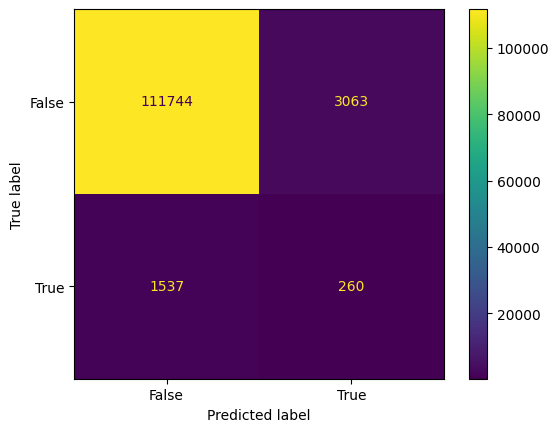

In [30]:
m2_test_results = test_metrics(model_2, x_test_scaled, y_test)

## Model 3
Adding an additional dense layer

In [31]:

model_3 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [32]:
model_3.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [33]:

history = model_3.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 36s 1ms/step - loss: 0.3982 - binary_accuracy: 0.8272 - recall_2: 0.7944 - precision: 0.8502 - val_loss: 0.2230 - val_binary_accuracy: 0.9575 - val_recall_2: 0.1575 - val_precision: 0.0760
Epoch 2/10
33486/33486 [==============================] - 33s 981us/step - loss: 0.2607 - binary_accuracy: 0.8933 - recall_2: 0.8291 - precision: 0.9512 - val_loss: 0.2141 - val_binary_accuracy: 0.9583 - val_recall_2: 0.1497 - val_precision: 0.0746
Epoch 3/10
33486/33486 [==============================] - 33s 998us/step - loss: 0.2425 - binary_accuracy: 0.9018 - recall_2: 0.8366 - precision: 0.9622 - val_loss: 0.0976 - val_binary_accuracy: 0.9846 - val_recall_2: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
33486/33486 [==============================] - 33s 985us/step - loss: 0.2384 - binary_accuracy: 0.9041 - recall_2: 0.8379 - precision: 0.9658 - val_loss: 0.1949 - val_binary_accuracy: 0.9706 - val_recall_2: 0.0818 - val_precision: 0.076

3644/3644 [==============================] - 2s 585us/step
Best Threshold: 0.296
Accuracy: 0.9563651332715859
Precision: 0.07137275332117739
Recall: 0.15247634947134112
F1-Score: 0.09723207948899928
AUC: 0.7195189871750067
Confusion Matrix:
[[111242   3565]
 [  1523    274]]


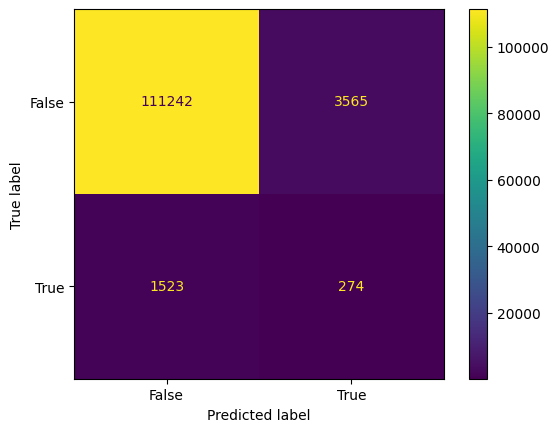

In [34]:
m3_test_results = test_metrics(model_3, x_test_scaled, y_test)

## Model 4
Testing model architecture with bias in fully connected layers

In [35]:
model_4 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],), use_bias=True),
    tf.keras.layers.Dense(32, activation='relu',  use_bias=True),
    tf.keras.layers.Dense(32, activation='relu',  use_bias=True),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [36]:
model_4.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [72]:
history = model_4.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4995 - recall_3: 0.5024 - precision_1: 0.4995 - val_loss: 0.6895 - val_binary_accuracy: 0.9846 - val_recall_3: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 2/10
33486/33486 [==============================] - 37s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4994 - recall_3: 0.5265 - precision_1: 0.4995 - val_loss: 0.6905 - val_binary_accuracy: 0.9846 - val_recall_3: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 3/10
33486/33486 [==============================] - 37s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4998 - recall_3: 0.4784 - precision_1: 0.4998 - val_loss: 0.7048 - val_binary_accuracy: 0.0154 - val_recall_3: 1.0000 - val_precision_1: 0.0154
Epoch 4/10
33486/33486 [==============================] - 37s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4992 - recall_3: 0.5338 - precision_1: 0.4993 - val_loss: 0.7024 - val_binary_accuracy: 0.0154 - val_recall_3: 1.0000 - val_

3644/3644 [==============================] - 3s 729us/step
Best Threshold: 0.0
Accuracy: 0.015411135124009469
Precision: 0.015411135124009469
Recall: 1.0
F1-Score: 0.030354473357488535
AUC: 0.5
Confusion Matrix:
[[     0 114807]
 [     0   1797]]


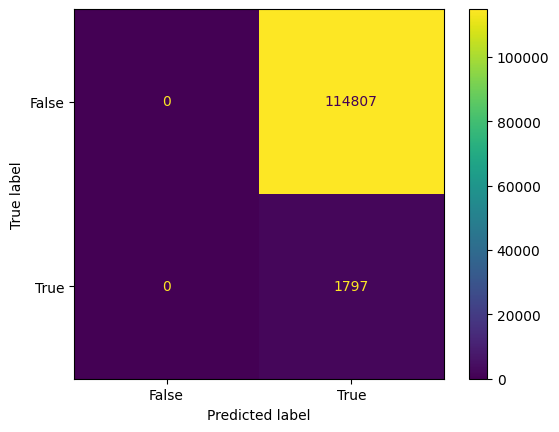

In [73]:
m4_test_results = test_metrics(model_4, x_test_scaled, y_test)

## Model 5
Adding drop out layers

In [39]:
model_5 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu',  use_bias=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [40]:
model_5.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [41]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_5.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 36s 1ms/step - loss: 0.9023 - binary_accuracy: 0.4994 - recall_4: 0.5132 - precision_2: 0.4994 - val_loss: 0.6895 - val_binary_accuracy: 0.9846 - val_recall_4: 0.0000e+00 - val_precision_2: 0.0000e+00
Epoch 2/10
33486/33486 [==============================] - 36s 1ms/step - loss: 0.6935 - binary_accuracy: 0.4995 - recall_4: 0.5237 - precision_2: 0.4995 - val_loss: 0.6905 - val_binary_accuracy: 0.9846 - val_recall_4: 0.0000e+00 - val_precision_2: 0.0000e+00
Epoch 3/10
33486/33486 [==============================] - 38s 1ms/step - loss: 0.6934 - binary_accuracy: 0.4998 - recall_4: 0.4777 - precision_2: 0.4998 - val_loss: 0.7048 - val_binary_accuracy: 0.0154 - val_recall_4: 1.0000 - val_precision_2: 0.0154
Epoch 4/10
33486/33486 [==============================] - 40s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4993 - recall_4: 0.5338 - precision_2: 0.4993 - val_loss: 0.7024 - val_binary_accuracy: 0.0154 - val_recall_4: 1.0000 - val_

3644/3644 [==============================] - 3s 717us/step
Best Threshold: 0.0
Accuracy: 0.015411135124009469
Precision: 0.015411135124009469
Recall: 1.0
F1-Score: 0.030354473357488535
AUC: 0.5
Confusion Matrix:
[[     0 114807]
 [     0   1797]]


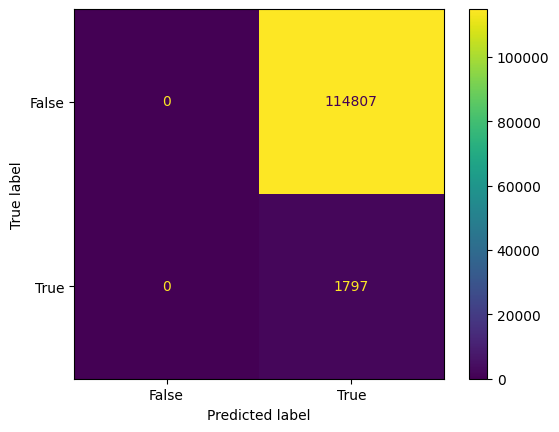

In [71]:
m5_test_results = test_metrics(model_5, x_test_scaled, y_test)

## Model 6
Switching to Leaky Relu as the activation function

In [43]:
model_6 = Sequential([
    tf.keras.layers.Dense(64, input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [44]:
model_6.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [45]:
history = model_6.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 38s 1ms/step - loss: 0.6193 - binary_accuracy: 0.7685 - recall_5: 0.7402 - precision_3: 0.7846 - val_loss: 0.2376 - val_binary_accuracy: 0.9759 - val_recall_5: 0.0634 - val_precision_3: 0.0919
Epoch 2/10
33486/33486 [==============================] - 38s 1ms/step - loss: 0.2936 - binary_accuracy: 0.8750 - recall_5: 0.8160 - precision_3: 0.9252 - val_loss: 0.3750 - val_binary_accuracy: 0.8498 - val_recall_5: 0.4218 - val_precision_3: 0.0440
Epoch 3/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.2675 - binary_accuracy: 0.8881 - recall_5: 0.8271 - precision_3: 0.9421 - val_loss: 0.0763 - val_binary_accuracy: 0.9846 - val_recall_5: 0.0000e+00 - val_precision_3: 0.0000e+00
Epoch 4/10
33486/33486 [==============================] - 40s 1ms/step - loss: 0.2526 - binary_accuracy: 0.8952 - recall_5: 0.8336 - precision_3: 0.9508 - val_loss: 0.1818 - val_binary_accuracy: 0.9834 - val_recall_5: 0.0128 - val_precisio

3644/3644 [==============================] - 2s 619us/step
Best Threshold: 0.35000000000000003
Accuracy: 0.9383554595039622
Precision: 0.06220561961994478
Recall: 0.21313299944351696
F1-Score: 0.09630374654262007
AUC: 0.7178832982671036
Confusion Matrix:
[[109033   5774]
 [  1414    383]]


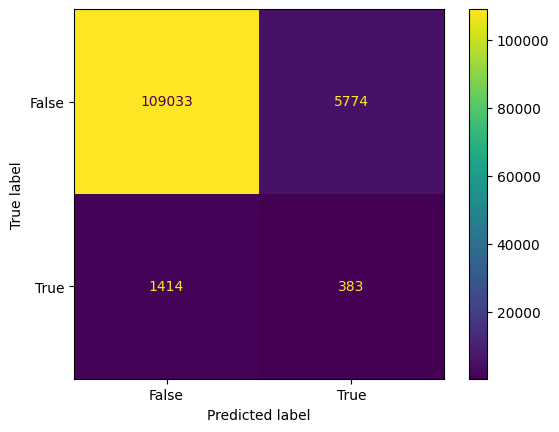

In [46]:
m6_test_results = test_metrics(model_6, x_test_scaled, y_test)

## Model 7
Adding another Dense layer

In [47]:
model_7 = Sequential([
    tf.keras.layers.Dense(64, input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [48]:
model_7.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [49]:
history = model_7.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 40s 1ms/step - loss: 0.6390 - binary_accuracy: 0.6799 - recall_6: 0.6546 - precision_4: 0.6894 - val_loss: 0.2690 - val_binary_accuracy: 0.9165 - val_recall_6: 0.2866 - val_precision_4: 0.0574
Epoch 2/10
33486/33486 [==============================] - 40s 1ms/step - loss: 0.2993 - binary_accuracy: 0.8720 - recall_6: 0.8049 - precision_4: 0.9297 - val_loss: 0.1726 - val_binary_accuracy: 0.9826 - val_recall_6: 0.0200 - val_precision_4: 0.1180
Epoch 3/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.2728 - binary_accuracy: 0.8854 - recall_6: 0.8196 - precision_4: 0.9438 - val_loss: 0.1988 - val_binary_accuracy: 0.9833 - val_recall_6: 0.0122 - val_precision_4: 0.1164
Epoch 4/10
33486/33486 [==============================] - 40s 1ms/step - loss: 0.2581 - binary_accuracy: 0.8922 - recall_6: 0.8279 - precision_4: 0.9501 - val_loss: 0.2029 - val_binary_accuracy: 0.9769 - val_recall_6: 0.0573 - val_precision_4: 0.0

3644/3644 [==============================] - 2s 633us/step
Best Threshold: 0.341
Accuracy: 0.9460052828376385
Precision: 0.06682072020026959
Recall: 0.1930996104618809
F1-Score: 0.09928469241773963
AUC: 0.7200087350875216
Confusion Matrix:
[[109961   4846]
 [  1450    347]]


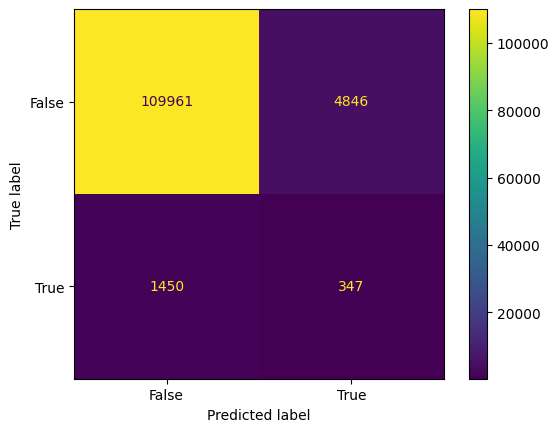

In [50]:
m7_test_results = test_metrics(model_7, x_test_scaled, y_test)

# Model 8
Adding more filters to the Dense layers

In [51]:
model_8 = Sequential([
    tf.keras.layers.Dense(64, input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [52]:
model_8.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Recall(thresholds = 0.4), tf.keras.metrics.Precision()]
)

In [53]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_8.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32,
                    )

Epoch 1/10
33486/33486 [==============================] - 40s 1ms/step - loss: 0.6020 - recall_7: 0.8724 - precision_5: 0.7024 - val_loss: 0.1738 - val_recall_7: 0.1408 - val_precision_5: 0.0911
Epoch 2/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.2984 - recall_7: 0.8408 - precision_5: 0.9278 - val_loss: 0.0957 - val_recall_7: 0.0022 - val_precision_5: 0.1667
Epoch 3/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.2705 - recall_7: 0.8451 - precision_5: 0.9458 - val_loss: 0.2044 - val_recall_7: 0.1308 - val_precision_5: 0.0962
Epoch 4/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.2566 - recall_7: 0.8509 - precision_5: 0.9524 - val_loss: 0.3031 - val_recall_7: 0.3272 - val_precision_5: 0.0574
Epoch 5/10
33486/33486 [==============================] - 38s 1ms/step - loss: 0.2458 - recall_7: 0.8576 - precision_5: 0.9552 - val_loss: 0.1441 - val_recall_7: 0.0902 - val_precision_5: 0.1035
Epoch 6/10
33486/33486 [=

3644/3644 [==============================] - 2s 639us/step
Best Threshold: 0.28600000000000003
Accuracy: 0.9619138279990395
Precision: 0.08138062064597847
Recall: 0.14301613800779076
F1-Score: 0.10373360242179616
AUC: 0.7239291976882798
Confusion Matrix:
[[111906   2901]
 [  1540    257]]


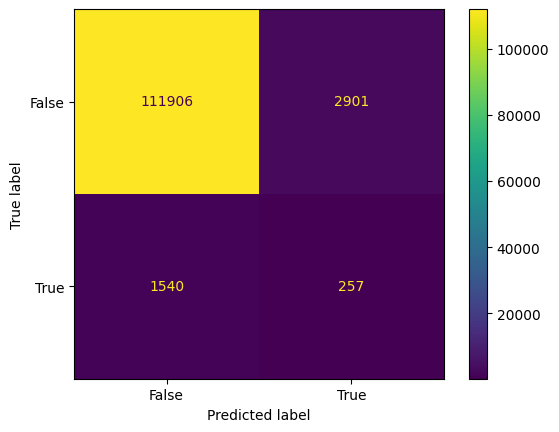

In [54]:
m8_test_results = test_metrics(model_8, x_test_scaled, y_test)

## Results ordering

In [55]:
all_results = {
    'model_1': m1_test_results,
    'model_2': m2_test_results,
    'model_3': m3_test_results,
    'model_4': m4_test_results,
    'model_5': m5_test_results,
    'model_6': m6_test_results,
    'model_7': m7_test_results,
    'model_8': m8_test_results,
}

In [56]:
results_df = pd.DataFrame.from_dict(all_results, orient='index')
sorted_df = results_df.sort_values(by='F1-Score', ascending=False)
sorted_df

,Best Threshold,Accuracy,Precision,Recall,F1-Score,AUC,Confusion Matrix
model_8,0.286,0.961914,0.081381,0.143016,0.103734,0.723929,"[[111906, 2901], [1540, 257]]"
model_1,0.054,0.951425,0.071571,0.179744,0.102377,0.745009,"[[110617, 4190], [1474, 323]]"
model_2,0.432,0.960550,0.078243,0.144686,0.101562,0.720399,"[[111744, 3063], [1537, 260]]"
model_7,0.341,0.946005,0.066821,0.193100,0.099285,0.720009,"[[109961, 4846], [1450, 347]]"
model_3,0.296,0.956365,0.071373,0.152476,0.097232,0.719519,"[[111242, 3565], [1523, 274]]"
model_6,0.350,0.938355,0.062206,0.213133,0.096304,0.717883,"[[109033, 5774], [1414, 383]]"
model_4,0.000,0.015411,0.015411,1.000000,0.030354,0.500000,"[[0, 114807], [0, 1797]]"
model_5,0.000,0.015411,0.015411,1.000000,0.030354,0.500000,"[[0, 114807], [0, 1797]]"


## RNN Model

### Analysis: 

**After running the initial RNN model, we tested multiple variations of:** 
- modifying the metrics to with permutations of recall, precision, F1 score and accuracy -> including recall is best
- different thresholds for recall and precision -> recall below 0.4 causes every true positive to be caught with low precision
- decreasing the dropout rate -> 0.2 is best
- enhance the optimizer to include a learning rate (between 1e-3 and 1e-6) -> smaller is better
- decreasing the number of epochs because the model appears to be overtraining -> decreasing results after 3 epochs
- batch sizes of 16, 32, and 64 -> 32 is best
- using SMOTE and non-SMOTE training variables -> SMOTE is clearly better
- Implemented a customer F1 score function to work with binary problems due to keras.metrics.F1Score producing errors.

From modifying these hyperparameters, computing time was not a significant consideration since we used a GPU. 
We prioritized the best results we could achieve over computing time.


## RNN Model 1  

In [194]:
embedding_dim = 32
max_features = 500000

model_r1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [195]:
model_r1.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [189]:
print(x_train_scaled.shape)
print(x_train_resampled.shape)
print(y_train_resampled.shape)
print(x_val_scaled.shape)
print(y_val.shape)

(544152, 61)
(1071532, 61)
(1071532,)
(116604, 61)
(116604,)


In [196]:
#np.random.seed(33)
#tf.random.set_seed(33)

history = model_r1.fit(x_train_resampled, y_train_resampled,
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 217s 6ms/step - loss: 0.4673 - binary_accuracy: 0.7776 - recall_14: 0.7694 - precision_10: 0.7822 - val_loss: 1.4195 - val_binary_accuracy: 0.3267 - val_recall_14: 0.6984 - val_precision_10: 0.0158
Epoch 2/10
33486/33486 [==============================] - 212s 6ms/step - loss: 0.4427 - binary_accuracy: 0.7912 - recall_14: 0.7836 - precision_10: 0.7958 - val_loss: 1.0081 - val_binary_accuracy: 0.5007 - val_recall_14: 0.5181 - val_precision_10: 0.0160
Epoch 3/10
33486/33486 [==============================] - 212s 6ms/step - loss: 0.4373 - binary_accuracy: 0.7944 - recall_14: 0.7867 - precision_10: 0.7991 - val_loss: 0.8007 - val_binary_accuracy: 0.6017 - val_recall_14: 0.4101 - val_precision_10: 0.0160
Epoch 4/10
33486/33486 [==============================] - 212s 6ms/step - loss: 0.4338 - binary_accuracy: 0.7971 - recall_14: 0.7896 - precision_10: 0.8016 - val_loss: 0.6942 - val_binary_accuracy: 0.6605 - val_recall_14: 0.3467 - v

3644/3644 [==============================] - 4s 1ms/step
Best Threshold: 0.10101010101010102
Accuracy: 0.5281379712531302
Precision: 0.01642680622183457
Recall: 0.5030606566499721
F1-Score: 0.031814742473033134
AUC: 0.5186243706799428
Confusion Matrix:
[[60679 54128]
 [  893   904]]


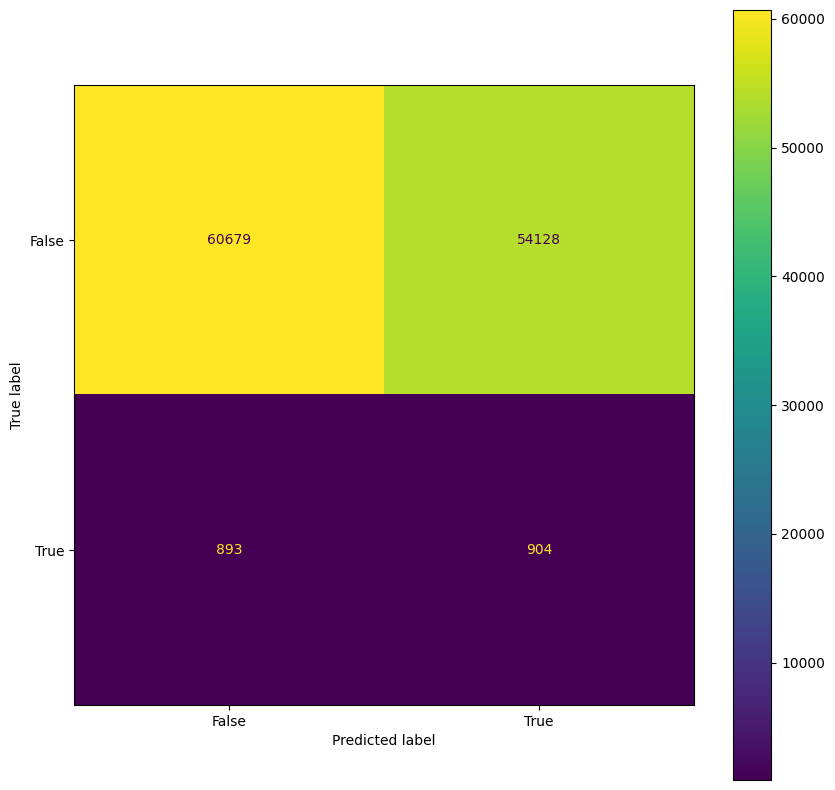

In [198]:
#import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

RNN1_test_results = test_metrics(model_r1, x_test_scaled, y_test)

## RNN Model 2

In [55]:
embedding_dim = 32
max_features = 500000

model_r1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [64]:
model_r1.compile(
    #optimizer = 'adam',
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Recall(thresholds = 0.4), tf.keras.metrics.Precision()] #####
)

In [60]:
print(x_train_scaled.shape)
print(x_train_resampled.shape)
print(y_train_resampled.shape)
print(x_val_scaled.shape)
print(y_val.shape)

(1071532, 61)
(1071532, 61)
(1071532,)
(116604, 61)
(116604,)


#### recall threshold of 0.4, learning rate = 1e-5

In [65]:
#np.random.seed(33)
#tf.random.set_seed(33)

history = model_r1.fit(x_train_resampled, y_train_resampled,
                    validation_data=(x_val_scaled, y_val),
                    epochs=3,
                    batch_size=32)

Epoch 1/3
33486/33486 [==============================] - 126s 4ms/step - loss: 0.5484 - recall_3: 0.8864 - precision_3: 0.7378 - val_loss: 0.8125 - val_recall_3: 0.7312 - val_precision_3: 0.0154
Epoch 2/3
33486/33486 [==============================] - 122s 4ms/step - loss: 0.5303 - recall_3: 0.8730 - precision_3: 0.7459 - val_loss: 0.8608 - val_recall_3: 0.7145 - val_precision_3: 0.0153
Epoch 3/3
33486/33486 [==============================] - 121s 4ms/step - loss: 0.5163 - recall_3: 0.8652 - precision_3: 0.7531 - val_loss: 0.9253 - val_recall_3: 0.7173 - val_precision_3: 0.0153


3644/3644 [==============================] - 4s 1ms/step
Best Threshold: 0.36363636363636365
Accuracy: 0.25716956536653973
Precision: 0.016209988364399627
Recall: 0.7907623817473567
F1-Score: 0.031768743223152505
AUC: 0.5167600311183009
Confusion Matrix:
[[28566 86241]
 [  376  1421]]


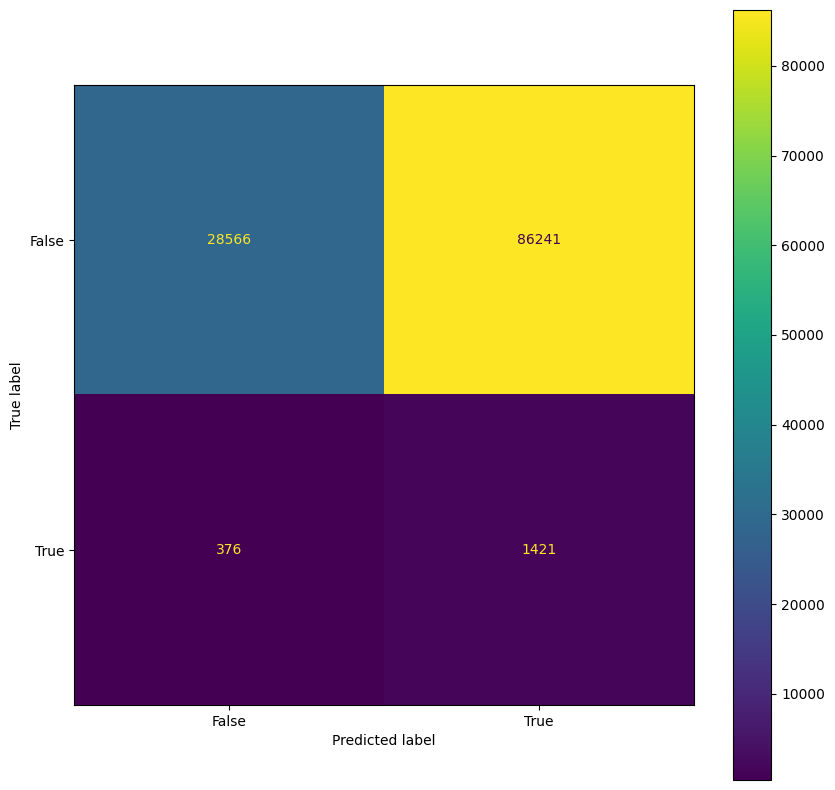

In [66]:
plt.rcParams["figure.figsize"] = (10,10)

RNN1_test_results = test_metrics(model_r1, x_test_scaled, y_test)

## RNN Model 3

#### recall threshold of 0.45, learning rate = 1e-5

In [61]:
#np.random.seed(33)
#tf.random.set_seed(33)

history = model_r1.fit(x_train_resampled, y_train_resampled,
                    validation_data=(x_val_scaled, y_val),
                    epochs=3,
                    batch_size=32)

Epoch 1/3
33486/33486 [==============================] - 126s 4ms/step - loss: 0.6367 - recall_1: 0.9268 - precision_1: 0.7128 - val_loss: 0.7050 - val_recall_1: 0.7540 - val_precision_1: 0.0157
Epoch 2/3
33486/33486 [==============================] - 122s 4ms/step - loss: 0.6024 - recall_1: 0.8691 - precision_1: 0.7200 - val_loss: 0.7284 - val_recall_1: 0.6750 - val_precision_1: 0.0157
Epoch 3/3
33486/33486 [==============================] - 121s 4ms/step - loss: 0.5722 - recall_1: 0.8390 - precision_1: 0.7289 - val_loss: 0.7762 - val_recall_1: 0.6600 - val_precision_1: 0.0155


3644/3644 [==============================] - 5s 1ms/step
Best Threshold: 0.42424242424242425
Accuracy: 0.3073822510377002
Precision: 0.01623476076701587
Recall: 0.7373400111296605
F1-Score: 0.03177000911139884
AUC: 0.5192023288616202
Confusion Matrix:
[[34517 80290]
 [  472  1325]]


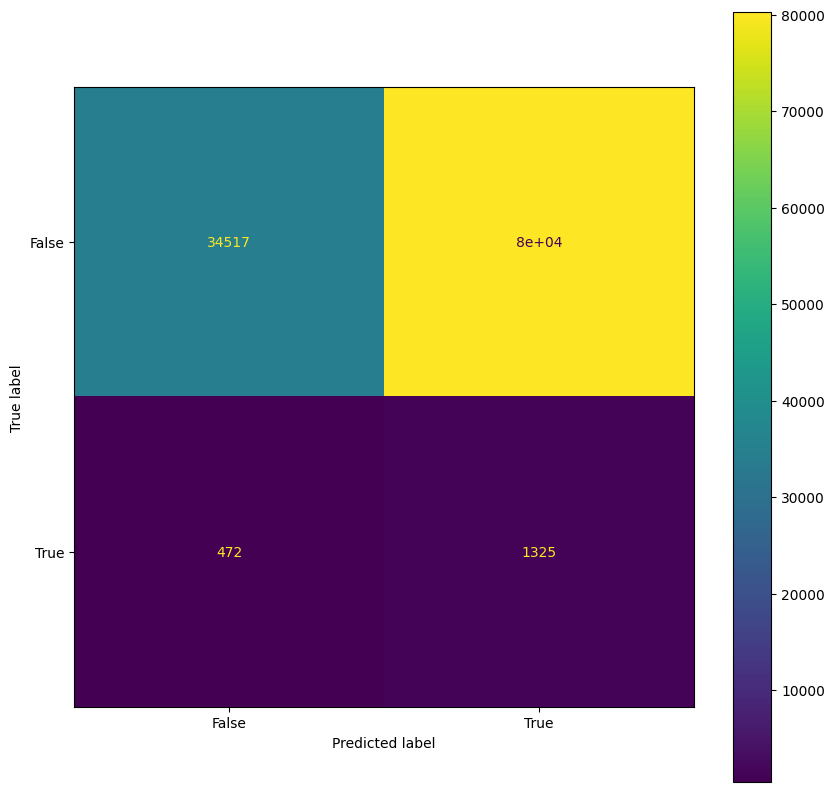

In [62]:
plt.rcParams["figure.figsize"] = (10,10)

RNN1_test_results = test_metrics(model_r1, x_test_scaled, y_test)

#### Custom F1 function

In [26]:
#### reference: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## RNN Model 4

In [24]:
from keras import backend as K

In [25]:
embedding_dim = 32
max_features = 500000

model_r1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [47]:
metric_list = [f1_m, recall_m] # we use F1 and recall 

model_r1.compile(
    #optimizer = 'adam',
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics = metric_list
    #metrics=[tf.keras.metrics.Recall(thresholds = 0.5), tf.keras.metrics.Precision(thresholds = 0.5)] #####
    #metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(thresholds = 0.4), tf.keras.metrics.Precision()]
    #metrics=[tf.keras.metrics.F1Score(threshold=0.5)]
)

##### using 6 epochs

In [53]:
#np.random.seed(33)
#tf.random.set_seed(33)

history = model_r1.fit(x_train_resampled, y_train_resampled,
                    validation_data=(x_val_scaled, y_val),
                    epochs=6,
                    batch_size=32)

Epoch 1/6
33486/33486 [==============================] - 124s 4ms/step - loss: 0.4205 - f1_m: 0.7990 - recall_m: 0.7985 - val_loss: 0.3170 - val_f1_m: 0.0252 - val_recall_m: 0.0529
Epoch 2/6
33486/33486 [==============================] - 122s 4ms/step - loss: 0.4204 - f1_m: 0.7987 - recall_m: 0.7981 - val_loss: 0.3170 - val_f1_m: 0.0247 - val_recall_m: 0.0520
Epoch 3/6
33486/33486 [==============================] - 123s 4ms/step - loss: 0.4201 - f1_m: 0.7991 - recall_m: 0.7986 - val_loss: 0.3220 - val_f1_m: 0.0253 - val_recall_m: 0.0537
Epoch 4/6
33486/33486 [==============================] - 122s 4ms/step - loss: 0.4203 - f1_m: 0.7990 - recall_m: 0.7987 - val_loss: 0.3186 - val_f1_m: 0.0248 - val_recall_m: 0.0526
Epoch 5/6
33486/33486 [==============================] - 122s 4ms/step - loss: 0.4204 - f1_m: 0.7985 - recall_m: 0.7975 - val_loss: 0.3185 - val_f1_m: 0.0247 - val_recall_m: 0.0523
Epoch 6/6
33486/33486 [==============================] - 122s 4ms/step - loss: 0.4203 - f1_m: 0

##### Results (6 epochs)

3644/3644 [==============================] - 4s 1ms/step
Best Threshold: 0.10101010101010102
Accuracy: 0.5080100168090288
Precision: 0.01637860512070736
Recall: 0.523650528658876
F1-Score: 0.03176371308016878
AUC: 0.518328226337551
Confusion Matrix:
[[58295 56512]
 [  856   941]]


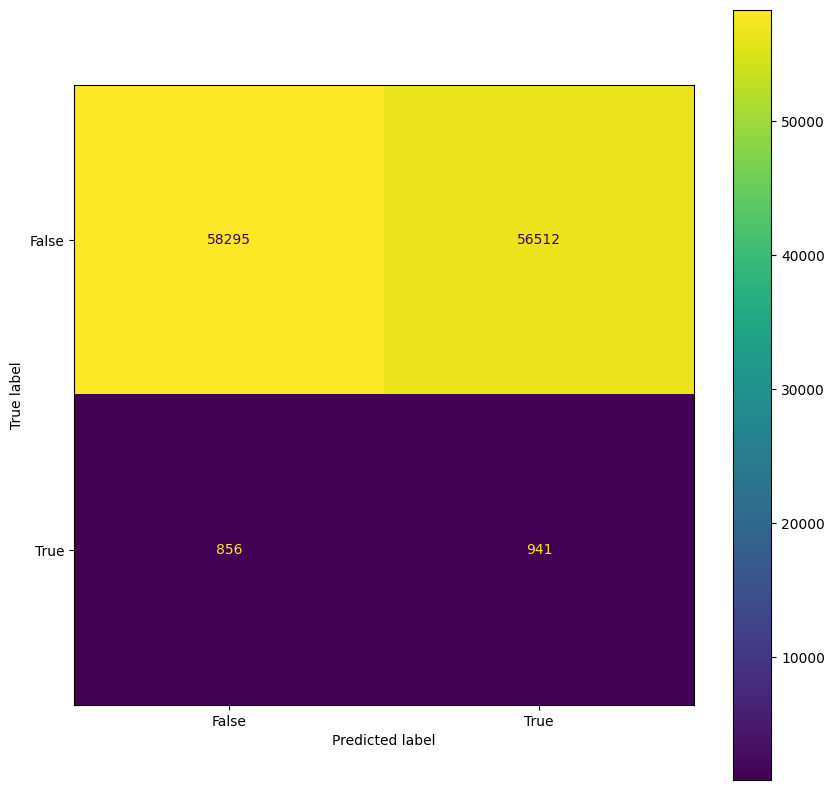

In [54]:
plt.rcParams["figure.figsize"] = (10,10)

RNN1_test_results = test_metrics(model_r1, x_test_scaled, y_test)

## RNN Model 5

##### using 3 epochs

In [51]:
#np.random.seed(33)
#tf.random.set_seed(33)

history = model_r1.fit(x_train_resampled, y_train_resampled,
                    validation_data=(x_val_scaled, y_val),
                    epochs=3,
                    batch_size=32)

Epoch 1/3
33486/33486 [==============================] - 128s 4ms/step - loss: 0.4025 - f1_m: 0.8110 - recall_m: 0.8101 - val_loss: 0.3196 - val_f1_m: 0.0251 - val_recall_m: 0.0531
Epoch 2/3
33486/33486 [==============================] - 121s 4ms/step - loss: 0.4067 - f1_m: 0.8083 - recall_m: 0.8078 - val_loss: 0.3177 - val_f1_m: 0.0253 - val_recall_m: 0.0530
Epoch 3/3
33486/33486 [==============================] - 122s 4ms/step - loss: 0.4061 - f1_m: 0.8086 - recall_m: 0.8077 - val_loss: 0.3241 - val_f1_m: 0.0252 - val_recall_m: 0.0537


##### results (3 epochs): using F1 & recall, batch = 32, learning_rate=1e-5, 3 epochs

3644/3644 [==============================] - 5s 1ms/step
Best Threshold: 0.10101010101010102
Accuracy: 0.49325923638983227
Precision: 0.01634389720904317
Recall: 0.5386755703951029
F1-Score: 0.03172522286313581
AUC: 0.5185021821165898
Confusion Matrix:
[[56548 58259]
 [  829   968]]


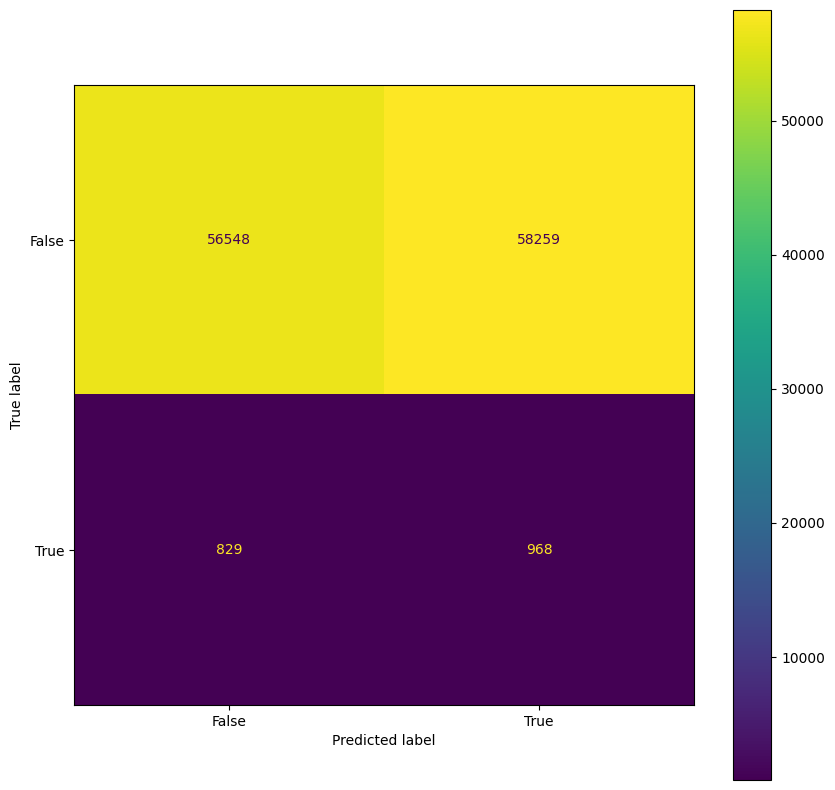

In [52]:
plt.rcParams["figure.figsize"] = (10,10)

RNN1_test_results = test_metrics(model_r1, x_test_scaled, y_test)

## LSTM Attempts

In [57]:
x_train_reshaped = np.expand_dims(x_train_scaled, axis=1)
x_val_reshaped = np.expand_dims(x_val_scaled, axis=1)
x_test_reshaped = np.expand_dims(x_test_scaled, axis = 1)

In [58]:
x_train_scaled.shape

(1071532, 61)

In [59]:
x_train_reshaped.shape

(1071532, 1, 61)

In [60]:
x_val_reshaped.shape

(116604, 1, 61)

## LSTM Model 1

In [61]:
num_features = x_train_scaled.shape[1]

model_r1 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(None, num_features)),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [62]:
model_r1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [63]:
np.random.seed(33)
tf.random.set_seed(33)


history = model_r1.fit(x_train_reshaped, y_train_resampled, 
                    validation_data=(x_val_reshaped, y_val),
                    epochs=10,
                    batch_size=32,
                    )

Epoch 1/10
33486/33486 [==============================] - 84s 2ms/step - loss: 0.6932 - binary_accuracy: 0.5004 - recall_8: 0.5232 - precision_6: 0.5004 - val_loss: 0.6896 - val_binary_accuracy: 0.9846 - val_recall_8: 0.0000e+00 - val_precision_6: 0.0000e+00
Epoch 2/10
33486/33486 [==============================] - 81s 2ms/step - loss: 0.6932 - binary_accuracy: 0.4996 - recall_8: 0.5266 - precision_6: 0.4996 - val_loss: 0.6896 - val_binary_accuracy: 0.9846 - val_recall_8: 0.0000e+00 - val_precision_6: 0.0000e+00
Epoch 3/10
33486/33486 [==============================] - 80s 2ms/step - loss: 0.6932 - binary_accuracy: 0.4996 - recall_8: 0.4775 - precision_6: 0.4996 - val_loss: 0.7042 - val_binary_accuracy: 0.0154 - val_recall_8: 1.0000 - val_precision_6: 0.0154
Epoch 4/10
33486/33486 [==============================] - 80s 2ms/step - loss: 0.6932 - binary_accuracy: 0.4994 - recall_8: 0.5222 - precision_6: 0.4994 - val_loss: 0.7028 - val_binary_accuracy: 0.0154 - val_recall_8: 1.0000 - val_

3644/3644 [==============================] - 5s 1ms/step
Best Threshold: 0.0
Accuracy: 0.015411135124009469
Precision: 0.015411135124009469
Recall: 1.0
F1-Score: 0.030354473357488535
AUC: 0.5
Confusion Matrix:
[[     0 114807]
 [     0   1797]]


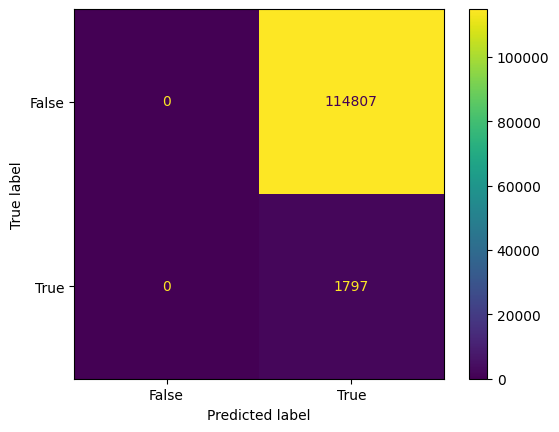

In [70]:
r1_test_results = test_metrics(model_r1, x_test_reshaped, y_test)

## LSTM Model 2  
Adding dense layer and Global Average Pooling

In [65]:
num_features = x_train_scaled.shape[1]

model_r2 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(None, num_features)),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [66]:
model_r2.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [67]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_r2.fit(x_train_reshaped, y_train_resampled, 
                    validation_data=(x_val_reshaped, y_val),
                    epochs=3,
                    batch_size=32
                    )

Epoch 1/3
33486/33486 [==============================] - 97s 3ms/step - loss: 0.6932 - binary_accuracy: 0.5002 - recall_9: 0.5206 - precision_7: 0.5002 - val_loss: 0.6895 - val_binary_accuracy: 0.9846 - val_recall_9: 0.0000e+00 - val_precision_7: 0.0000e+00
Epoch 2/3
33486/33486 [==============================] - 93s 3ms/step - loss: 0.6932 - binary_accuracy: 0.4994 - recall_9: 0.5265 - precision_7: 0.4995 - val_loss: 0.6905 - val_binary_accuracy: 0.9846 - val_recall_9: 0.0000e+00 - val_precision_7: 0.0000e+00
Epoch 3/3
33486/33486 [==============================] - 92s 3ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - recall_9: 0.4865 - precision_7: 0.4997 - val_loss: 0.7048 - val_binary_accuracy: 0.0154 - val_recall_9: 1.0000 - val_precision_7: 0.0154


3644/3644 [==============================] - 4s 1ms/step
Best Threshold: 0.0
Accuracy: 0.015411135124009469
Precision: 0.015411135124009469
Recall: 1.0
F1-Score: 0.030354473357488535
AUC: 0.5
Confusion Matrix:
[[     0 114807]
 [     0   1797]]


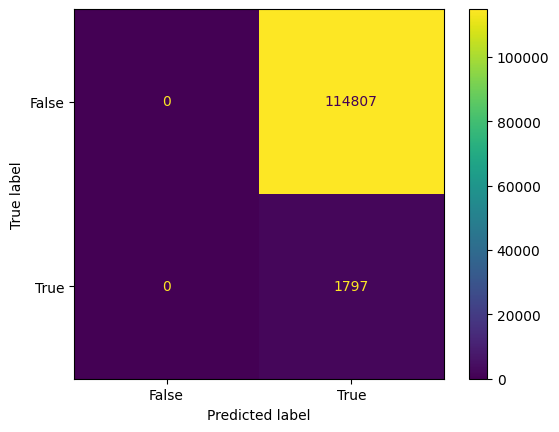

In [69]:
r2_test_results = test_metrics(model_r2, x_test_reshaped, y_test)